# 0. Imports

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tarfile
import os

# 1. Dataset

In [2]:
dataset_path = 'dataset'

In [105]:
if os.path.exists("dataset/train"):
    print("Dataset found! Skipping download.")
else:
    print("Dataset not found. Downloading and extracting it...")
    os.makedirs(dataset_path, exist_ok=True)
    !wget --show-progress https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar -O streethazards_train.tar
    with tarfile.open('streethazards_train.tar') as tar:
        tar.extractall(path='./dataset')
    os.remove('streethazards_train.tar')

Dataset found! Skipping download.


test dataset

In [3]:
os.makedirs(dataset_path, exist_ok=True)
!wget --show-progress https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar -O streethazards_test.tar
with tarfile.open('streethazards_test.tar') as tar:
    tar.extractall(path='./dataset')
os.remove('streethazards_test.tar')

--2025-04-23 16:06:50--  https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2150484992 (2.0G) [application/x-tar]
Saving to: ‘streethazards_test.tar’

streethazards_test. 100%[===================>]   2.00G  13.2MB/s    in 2m 24s  

2025-04-23 16:09:15 (14.3 MB/s) - ‘streethazards_test.tar’ saved [2150484992/2150484992]



In [33]:
import cv2

image_folder_test = os.path.join(dataset_path, "test/images/test/t6")
mask_folder_test = os.path.join(dataset_path, "test/annotations/test/t6")

len_dataset = len(os.listdir(image_folder_test))

idx = np.random.choice(len_dataset, size=None)

sample_image = read_image(os.path.join(image_folder_test,
                                sorted(os.listdir(image_folder_test))[idx]
                                ))
sample_mask = read_image(os.path.join(mask_folder_test,
                                sorted(os.listdir(mask_folder_test))[idx]
                                ))

mask_path = os.path.join(mask_folder_test, sorted(os.listdir(mask_folder_test))[idx])

sample_mask_cv2 = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
sample_mask_cv2 = torch.as_tensor(sample_mask_cv2, dtype=torch.uint8)

obj_ids = torch.unique(sample_mask)
print(idx)
print(obj_ids)
# plot_sample_image(sample_image, sample_mask, idx)

# plot_sample_image(sample_image, sample_mask_cv2, idx)

382
tensor([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14], dtype=torch.uint8)


# bro sta a vedere che il torch.unique ti ritorna valori a partire da uno...

In [134]:
image_folder = os.path.join(dataset_path, "train/images/training/t1-3")
mask_folder = os.path.join(dataset_path, "train/annotations/training/t1-3")

## bro be careful because you're using train_dataset.imgs to look for the name of the image

In [7]:
def plot_sample_image(sample_image, sample_mask, idx):
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(sample_image.permute(1,2,0))
    try:
        plt.title(f"Image {train_dataset.imgs[idx]}")
    except:
        plt.title(f"Image {idx}")
    plt.subplot(1,2,2)
    plt.imshow(sample_mask.permute(1,2,0))
    try:
        plt.title(f"Mask {train_dataset.imgs[idx]}")
    except:
        plt.title(f"Mask {idx}")

    plt.show()

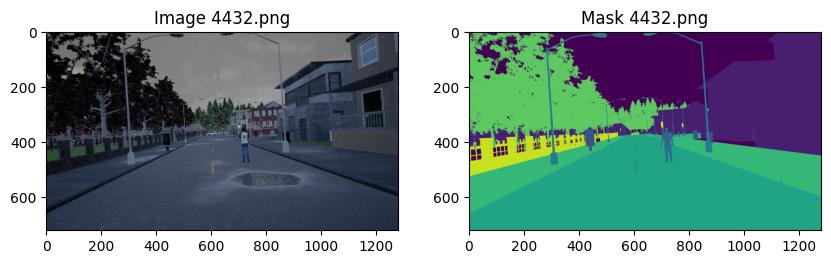

In [189]:
len_dataset = len(os.listdir(image_folder))

idx = np.random.choice(len_dataset, size=None)

sample_image = read_image(os.path.join(image_folder,
                                sorted(os.listdir(image_folder))[idx]
                                ))
sample_mask = read_image(os.path.join(mask_folder,
                                sorted(os.listdir(image_folder))[idx]
                                ))

plot_sample_image(sample_image, sample_mask, idx)

## most of the get_item has been taken from [this link](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In the code below, we are wrapping images, bounding boxes and masks into torchvision.tv_tensors.TVTensor classes so that we will be able to apply torchvision built-in transformations (new Transforms API) for the given object detection and segmentation task. Namely, image tensors will be wrapped by torchvision.tv_tensors.Image, bounding boxes into torchvision.tv_tensors.BoundingBoxes and masks into torchvision.tv_tensors.Mask. As torchvision.tv_tensors.TVTensor are torch.Tensor subclasses, wrapped objects are also tensors and inherit the plain torch.Tensor API.

In [111]:
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

class StreetHazardsTrain(Dataset):
    label_mapping = {
            0: "unlabeled",
            1: "building",
            2: "fence",
            3: "other",
            4: "pedestrian",
            5: "pole",
            6: "road line" ,
            7: "road",
            8: "sidewalk",
            9: "vegetation",
            10: "car",
            11: "wall",
            12: "traffic sign",
            13: "anomaly"
        }

    def __init__(self, split, transforms=None):
        self.split = split

        if self.split in ["train", "training"]:
            self.img_root = os.path.join(dataset_path, "train/images/training/t1-3")
            self.mask_root = os.path.join(dataset_path, "train/annotations/training/t1-3")
        else:
            self.img_root = os.path.join(dataset_path, "train/images/validation/t4")
            self.mask_root = os.path.join(dataset_path, "train/annotations/validation/t4")

        self.transforms = transforms
        self.imgs = sorted(os.listdir(self.img_root))
        self.masks = sorted(os.listdir(self.mask_root))


    def __getitem__(self, idx):
        img = read_image(os.path.join(self.img_root, self.imgs[idx]))
        mask = read_image(os.path.join(self.mask_root, self.masks[idx]))

        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)
        labels = torch.tensor([obj_id.item() for obj_id in obj_ids], dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        # i guess this is not useful in our scenario
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, mask, target


    def __len__(self):
        return len(self.imgs)

    @classmethod
    def get_label(cls, idx):
        return cls.label_mapping.get(idx, "unknown label")

In [112]:
train_dataset = StreetHazardsTrain(split="train")
validation_dataset = StreetHazardsTrain(split="validation")

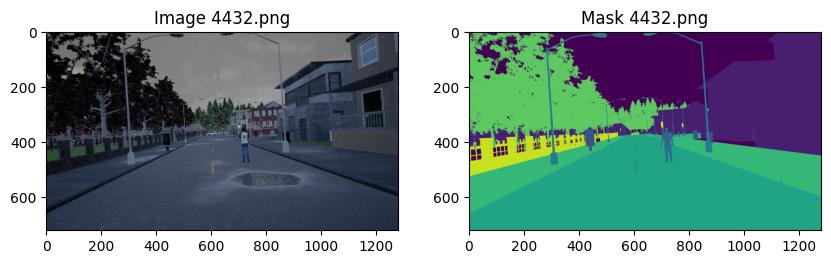

In [192]:
idx = 3815
sample_image, sample_mask, target = train_dataset[idx]

plot_sample_image(sample_image, sample_mask, idx)

In [193]:
sample_mask.shape

torch.Size([1, 720, 1280])

/usr/local/lib/python3.11/dist-packages/torchvision/utils.py:233: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


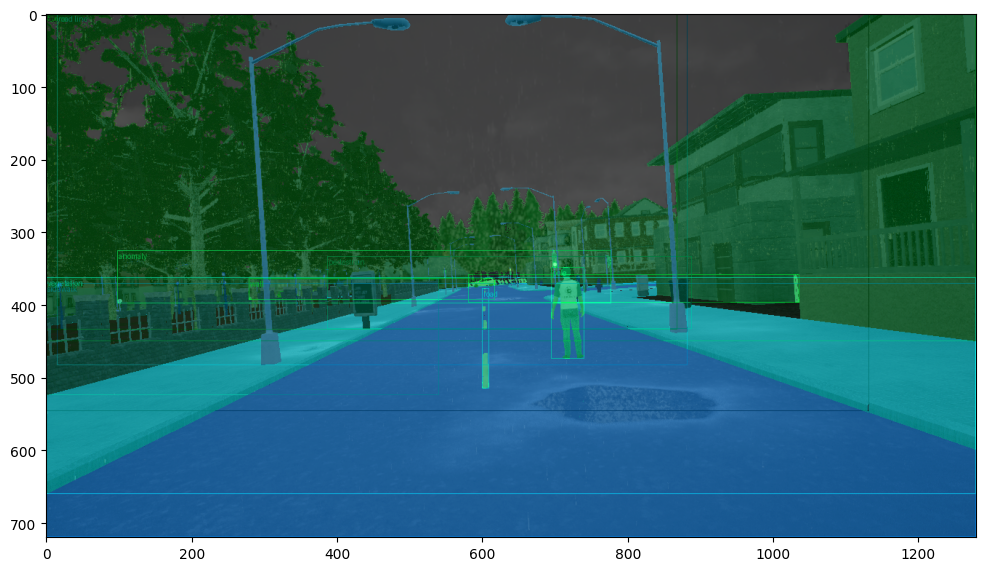

In [194]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
# eval_transform = get_transform(train=False)

# model.eval()
# with torch.no_grad():
#     x = eval_transform(image)
#     # convert RGBA -> RGB and move to device
#     x = x[:3, ...].to(device)
#     predictions = model([x, ])
#     pred = predictions[0]


image = (255.0 * (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{StreetHazardsTrain.get_label(label.item())}" for label in target["labels"]]
pred_boxes = target["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, font_size=200)

masks = (target["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5)


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [120]:
[label for label in target['labels']]

[tensor(1),
 tensor(2),
 tensor(3),
 tensor(6),
 tensor(7),
 tensor(8),
 tensor(9),
 tensor(10),
 tensor(12),
 tensor(13)]

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
print(f"Using {device}.")

Using cuda.
